# Project 2 Part 6

# intro

imports

In [2]:
# !pip install protobuf==3.20.0

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config


definitions

In [4]:
%load_ext autoreload 
%autoreload 2

import custom_functions as fn

config

In [5]:
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

data

In [6]:
# Load the joblib containing the data frame from Part 5 of the project.
df = joblib.load('Data-NLP/movie_reviews_preprocessed.pkl')
original_df = df.copy()
df.head()

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text
0,0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"['guilty', 'pleasure', 'personally', 'love', 'great', 'escape', 'works', 'seen', 'years', 'rightfully', 'esteemed', 'british', 'animation', 'company', 'highly', 'recommended', 'children', 'adults', 'enjoy', 'animation']","['guilty', 'pleasure', 'personally', 'love', 'great', 'escape', 'work', 'see', 'year', 'rightfully', 'esteem', 'british', 'animation', 'company', 'highly', 'recommend', 'child', 'adult', 'enjoy', 'animation']",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation
1,1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,Low,"['underwhelmed', 'straight', 'bored', 'course', 'seeing', 'hunt', 'climb', 'mountain', 'harness', 'impressive', 'sure', 'liked', 'idea', 'villain', 'piece', 'angle', 'woefully', 'underdeveloped', 'setting', 'predominantly', 'australia', 'grab', '...","['underwhelme', 'straight', 'bore', 'course', 'see', 'hunt', 'climb', 'mountain', 'harness', 'impressive', 'sure', 'like', 'idea', 'villain', 'piece', 'angle', 'woefully', 'underdeveloped', 'set', 'predominantly', 'australia', 'grab', 'attention'...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low poi...,underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossi...
2,2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,2.0,Low,"['entertainign', 'mission', 'impossible', 'second', 'installment', 'turned', 'terrible', 'screenwriters', 'know', 'fill', '2', 'hrs', 'action', 'overuse', 'heroic', 'slow', 'motion', 'scenes', 'horrible', 'need', 'barf', 'bag', 'stand', 'slo', 'm...","['entertainign', 'mission', 'impossible', 'second', 'installment', 'turn', 'terrible', 'screenwriter', 'know', 'fill', '2', 'hrs', 'action', 'overuse', 'heroic', 'slow', 'motion', 'scene', 'horrible', 'need', 'barf', 'bag', 'stand', 'slo', 'mo', ...",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece ...,entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat l...
3,3,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to roma

In [7]:
# Drop any reviews that do not have a rating.
df['rating'].isna().sum()

0

# Build Modeling Pipeline

Use the original review column as your X and the classification target (High/Low Rating Reviews) as your y.

In [8]:
X = df['review']
y = df[['sentiment']]

X.shape, y.shape

((2419,), (2419, 1))

In [9]:
# Instantiate the LabelEncoder
encoder = LabelEncoder()
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

c:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1    1224
0    1195
dtype: int64

In [10]:
df[['sentiment']].value_counts()

sentiment
Low          1224
High         1195
dtype: int64

Create a Text Vectorizer

In [11]:
# Train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)

In [12]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((1814,), (1814,), (605,), (605,))

In [13]:
# Create a pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'\b[a-zA-Z]+\b', stop_words='english', ngram_range=(1, 2))),
    ('clf', RandomForestClassifier())
])

In [14]:
pipeline.fit(X_train_full, y_train_full)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english',
                                 token_pattern='\\b[a-zA-Z]+\\b')),
                ('clf', RandomForestClassifier())])

predict

In [15]:
y_pred = pipeline.predict(X_test)

----------------------------------------------------------------------
 Classification Metrics: 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.86      0.81       299
           1       0.84      0.76      0.80       306

    accuracy                           0.81       605
   macro avg       0.81      0.81      0.81       605
weighted avg       0.81      0.81      0.81       605



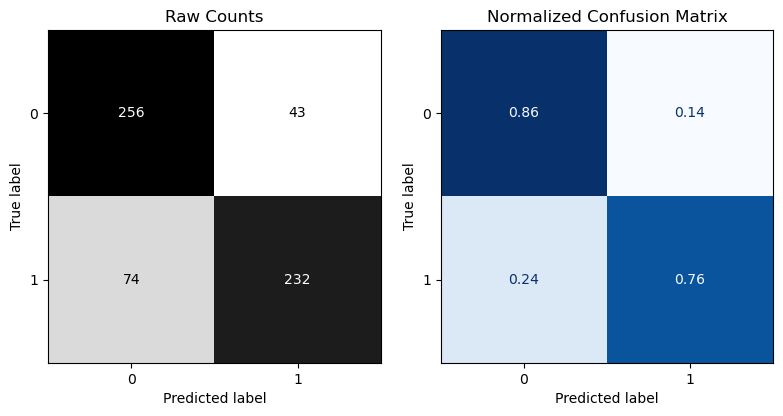

In [16]:
fn.classification_metrics(y_test, y_pred)

In a Markdown cell, document your observations from your results. (e.g., how good is the model overall? Is it particularly good/bad at predicting one class?)
  * The model is best at predicting low-rating movies (0, 0)

## GridSearch Text Vectorization

In [17]:
# grid_params = {
#     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'vect__min_df': [1, 2, 3],
#     'vect__max_df': [0.9, 0.95],
#     'vect__stop_words': [None, 'english']
# }

# grid_search = GridSearchCV(pipeline, grid_params, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(X_train_full, y_train_full)

What were the best parameters?

  * max_df: 0.95, min_df: 2, ngram_range: (1, 2), stop_words: english

In [18]:
# grid_search.best_params_

In [19]:
best_params = {
  'vect__max_df': 0.95,
  'vect__min_df': 3,
  'vect__ngram_range': (1, 1),
  'vect__stop_words': 'english'
}

How does the best estimator perform when evaluated on the training and test data?

In [20]:
#  Use the best parameters to fit the model
best_est = pipeline.set_params(**best_params)
best_est.fit(X_train_full, y_train_full)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.95, min_df=3, stop_words='english',
                                 token_pattern='\\b[a-zA-Z]+\\b')),
                ('clf', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       299
           1       0.84      0.82      0.83       306

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605



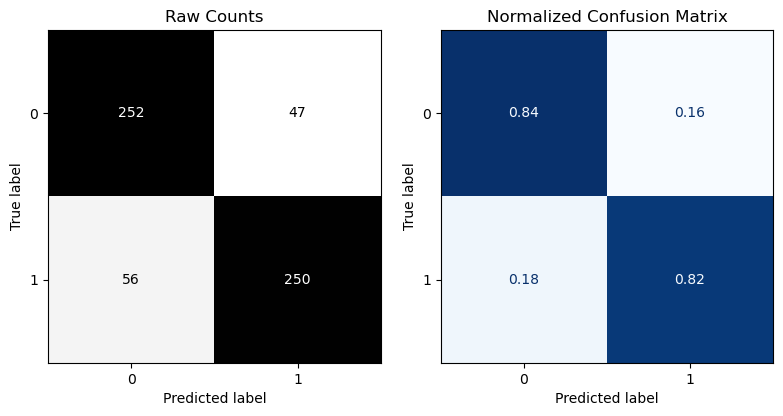

In [21]:
y_pred = best_est.predict(X_test)
fn.classification_metrics(y_test, y_pred)

In [25]:
X_train_full
# X_train_full.to_csv('Data-NLP/X_train_full.csv', index=False)
# y_train_full.to_csv('Data-NLP/y_train_full.csv', index=False)



462     A woman, Wendy (Michelle Williams), is trekking through America, well, she does have a car, although not of much use to her (it breaks down early on in the movie). She also has a dog, Lucy, whom she loses early in the movie. We have no idea where...
1315                                                                                                                                                                                                                                                    AMAZING!!
2257    _The Batman_ is the best live-action Batman movie yet. It's the type of Batman film I've been waiting for my whole life.\r\n\r\nIt's dark and realistic, but also stylish and large-scale. It's not limited by a commitment to realism like the Dark K...
1358    The _Transformers_ franchise has never been good. Some say that the series is "Dumb fun with good action and cool explosions. To me, that could maybe be used to describe only the third movie. The first one is promising

In [28]:
# Save your training data ([X_test, y_test]​))
# joblib.dump([X_train_full, y_train_full], 'Data-NLP/training_data.csv')

pd.concat([X_train_full, y_train_full]).to_csv('Data-NLP/training_data.csv', index=False, encoding = "utf-8")
pd.concat([X_test, y_test]).to_csv('Data-NLP/test_data.csv', index=False, encoding = "utf-8")

In [ ]:
# Save your test data ([X_test, y_test]​))
joblib.dump([X_test, y_test], 'Data-NLP/test_data.csv', encoding = "utf-8" )

In [23]:
# Save your target_lookup dictionary and/or your label encoder
joblib.dump(encoder, 'models/label_encoder.joblib')

['models/label_encoder.joblib']

In [24]:
# Save your best model
joblib.dump(best_est, 'models/best_model.joblib')

['models/best_model.joblib']

AttributeError: 'Pipeline' object has no attribute 'target_lookup'